### First experiments with U-Net on FOCI slp data

Trained model with **variable mask** and **augmentation factor 3** on samples with rel. amount of missing values in the **range of [0.50, 0.999]**.

Use this single model to find the **optimized sampling strategy** in a brute-force manner.

In [1]:
import os
import sys
sys.path.append('../reconstruct_missing_data')

from pathlib import Path
from json import dump, load

import numpy as np
import pandas as pd
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt

from data_loading import find_data_files, load_data_set, get_anomalies, clone_data, create_missing_mask, split_and_scale_data
from models import build_unet_4conv
from relevance import compute_single_relevance_map

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Lambda, concatenate, Conv1D, Conv2D, MaxPool2D, UpSampling2D, BatchNormalization, LeakyReLU
from tensorflow.keras.optimizers import Adam, SGD
import tensorflow.keras.initializers as tfi
import tensorflow.keras.regularizers as tfr
from tensorflow.keras.utils import plot_model

# Suppress Tensorflow warnings
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [2]:
# Set working directory, according to working directory in scripts:
os.chdir('/gxfs_work1/geomar/smomw511')

In [35]:
## Reload parameters and results for experiment:

# Specify experiment:
model_config = 'unet_4conv'
feature = 'sea-level-pressure' # Choose either 'sea-level-pressure' or 'sea-surface-temperature' as feature.
feature_short = 'slp' # Free to set short name, to store results, e.g. 'slp' and 'sst'.
source = 'FOCI' # Choose Earth System Model, either 'FOCI' or 'CESM'.
mask_type = 'variable'
missing_type = 'range_50_999'
augmentation_factor = 3
run = '_final'
exp_name = '/relevance_3'

# Get path to stored results:
path_to_stored_results = Path('GitGeomar/marco-landt-hayen/reconstruct_missing_data_results/'+model_config+'_'+feature_short+'_'+source+'_'
                      +mask_type+'_'+missing_type+'_factor_'+str(augmentation_factor)+run+exp_name)

print(path_to_stored_results)

# Reload parameters relevant for data pre-processing for this experiment:
with open(path_to_stored_results / 'parameters.json', 'r') as f:
    parameters=load(f)


train_val_split = parameters['train_val_split']
scale_to = parameters['scale_to']
n_samples = parameters['n_samples']
patch_size = parameters['patch_size']
max_patch_num = parameters['max_patch_num']
max_acc_rel_loss_reduction = parameters['max_acc_rel_loss_reduction']

# Print parameters:
print("\nnumber of samples: ", n_samples)
print("patch size: ", patch_size)
print("max. number of patches to include: ", max_patch_num)
print("max. acc. rel. loss as threshold: ", max_acc_rel_loss_reduction)

GitGeomar/marco-landt-hayen/reconstruct_missing_data_results/unet_4conv_slp_FOCI_variable_range_50_999_factor_3_final/relevance_3

number of samples:  120
patch size:  1
max. number of patches to include:  922
max. acc. rel. loss as threshold:  0.99


In [157]:
# ## For the following individual list of samples:

# relevance_3_samples = [
#     0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,23,24,25,26,27,28,29,30,31,32,34,35,36,38,39,
#     40,41,42,44,45,47,48,49,50,51,52,53,54,55,56,57,58,59,9530,9531,9532,9533,9534,9535,9536,9537,9538,9539,
#     9540,9541,9542,9543,9544,9545,9546,9548,9549,9550,9551,9553,9554,9555,9556,9557,9558,9559,9560,9561,9562,
#     9563,9564,9565,9566,9567,9568,9569,9570,9571,9572,9573,9574,9575,9576,9577,9578,9579,9580,9581,9582,9583,
#     9584,9585,9586,9587,9588,9589
# ]

# # Combine results:
# for n in relevance_3_samples:

#     ## rel_loss_reduction_maps:
    
#     # Define filename, according to sample number.
#     # Reload result for sample.
#     # Concatenate result with all results.  
#     # Define filename for all samples.
#     # Save results for all samples.
#     file_name_rel_loss_reduction_map = "rel_loss_reduction_map_sample_"+str(n)+".npy"
#     rel_loss_reduction_map = np.load(path_to_stored_results / file_name_rel_loss_reduction_map)
#     # Initialize storage for sample 0:
#     if n == 0:
#         rel_loss_reduction_maps = np.expand_dims(rel_loss_reduction_map,axis=0)
#     else:
#         rel_loss_reduction_maps = np.concatenate([rel_loss_reduction_maps,np.expand_dims(rel_loss_reduction_map,axis=0)])
# file_name_rel_loss_reduction_maps = "rel_loss_reduction_maps.npy"
# np.save(path_to_stored_results / file_name_rel_loss_reduction_maps, rel_loss_reduction_maps)
    
# # Combine results:
# for n in relevance_3_samples:  

#     ## patch_orders:
    
#     # Define filename, according to sample number.
#     # Reload result for sample.
#     # Concatenate result with all results.  
#     # Define filename for all samples.
#     # Save results for all samples.
#     file_name_patch_order = "patch_order_sample_"+str(n)+".npy"
#     patch_order = np.load(path_to_stored_results / file_name_patch_order)
#     # Initialize storage for sample 0:
#     if n == 0:
#         patch_orders = np.expand_dims(patch_order,axis=0)
#     else:
#         patch_orders = np.concatenate([patch_orders,np.expand_dims(patch_order,axis=0)])
# file_name_patch_orders = "patch_orders.npy"
# np.save(path_to_stored_results / file_name_patch_orders, patch_orders)
     
# # Combine results:
# for n in relevance_3_samples:  

#     ## abs_loss_reduction:
    
#     # Define filename, according to sample number.
#     # Reload result for sample.
#     # Concatenate result with all results.  
#     # Define filename for all samples.
#     # Save results for all samples.
#     file_name_abs_loss_reduction = "abs_loss_reduction_sample_"+str(n)+".npy"
#     abs_loss_reduction = np.load(path_to_stored_results / file_name_abs_loss_reduction)
#     # Initialize storage for sample 0:
#     if n == 0:
#         abs_loss_reductions = np.expand_dims(abs_loss_reduction,axis=0)
#     else:
#         abs_loss_reductions = np.concatenate([abs_loss_reductions,np.expand_dims(abs_loss_reduction,axis=0)])
# file_name_abs_loss_reductions = "abs_loss_reductions.npy"
# np.save(path_to_stored_results / file_name_abs_loss_reductions, abs_loss_reductions)
    
# # Combine results:
# for n in relevance_3_samples:  

#     ## rel_loss_reduction:
    
#     # Define filename, according to sample number.
#     # Reload result for sample.
#     # Concatenate result with all results.  
#     # Define filename for all samples.
#     # Save results for all samples.
#     file_name_rel_loss_reduction = "rel_loss_reduction_sample_"+str(n)+".npy"
#     rel_loss_reduction = np.load(path_to_stored_results / file_name_rel_loss_reduction)
#     # Initialize storage for sample 0:
#     if n == 0:
#         rel_loss_reductions = np.expand_dims(rel_loss_reduction,axis=0)
#     else:    
#         rel_loss_reductions = np.concatenate([rel_loss_reductions,np.expand_dims(rel_loss_reduction,axis=0)])
# file_name_rel_loss_reductions = "rel_loss_reductions.npy"
# np.save(path_to_stored_results / file_name_rel_loss_reductions, rel_loss_reductions)
    
# # Combine results:
# for n in relevance_3_samples:   

#     ## acc_rel_loss_reduction:
    
#     # Define filename, according to sample number.
#     # Reload result for sample.
#     # Concatenate result with all results.  
#     # Define filename for all samples.
#     # Save results for all samples.
#     file_name_acc_rel_loss_reduction = "acc_rel_loss_reduction_sample_"+str(n)+".npy"
#     acc_rel_loss_reduction = np.load(path_to_stored_results / file_name_acc_rel_loss_reduction)
#     # Initialize storage for sample 0:
#     if n == 0:
#         acc_rel_loss_reductions = np.expand_dims(acc_rel_loss_reduction,axis=0)
#     else:
#         acc_rel_loss_reductions = np.concatenate([acc_rel_loss_reductions,np.expand_dims(acc_rel_loss_reduction,axis=0)])
# file_name_acc_rel_loss_reductions = "acc_rel_loss_reductions.npy"
# np.save(path_to_stored_results / file_name_acc_rel_loss_reductions, acc_rel_loss_reductions)

# print("rel_loss_reduction_maps:", rel_loss_reduction_maps.shape)
# print("patch_orders:", patch_orders.shape)
# print("rel_loss_reductions:", rel_loss_reductions.shape)
# print("abs_loss_reductions:", abs_loss_reductions.shape)
# print("acc_rel_loss_reductions:", acc_rel_loss_reductions.shape)

In [61]:
# ## For complete list of samples:

# start_at = 0
# end_at = start_at + n_samples

# # Combine results:
# for n in np.arange(start_at,end_at): 

#     ## rel_loss_reduction_maps:
    
#     # Define filename, according to sample number.
#     # Reload result for sample.
#     # Concatenate result with all results.  
#     # Define filename for all samples.
#     # Save results for all samples.
#     file_name_rel_loss_reduction_map = "rel_loss_reduction_map_sample_"+str(n)+".npy"
#     rel_loss_reduction_map = np.load(path_to_stored_results / file_name_rel_loss_reduction_map)
#     # Initialize storage for sample 0:
#     if n == 0:
#         rel_loss_reduction_maps = np.expand_dims(rel_loss_reduction_map,axis=0)
#     else:
#         rel_loss_reduction_maps = np.concatenate([rel_loss_reduction_maps,np.expand_dims(rel_loss_reduction_map,axis=0)])
# file_name_rel_loss_reduction_maps = "rel_loss_reduction_maps.npy"
# np.save(path_to_stored_results / file_name_rel_loss_reduction_maps, rel_loss_reduction_maps)
    
# # Combine results:
# for n in np.arange(start_at,end_at):    

#     ## patch_orders:
    
#     # Define filename, according to sample number.
#     # Reload result for sample.
#     # Concatenate result with all results.  
#     # Define filename for all samples.
#     # Save results for all samples.
#     file_name_patch_order = "patch_order_sample_"+str(n)+".npy"
#     patch_order = np.load(path_to_stored_results / file_name_patch_order)
#     # Initialize storage for sample 0:
#     if n == 0:
#         patch_orders = np.expand_dims(patch_order,axis=0)
#     else:
#         patch_orders = np.concatenate([patch_orders,np.expand_dims(patch_order,axis=0)])
# file_name_patch_orders = "patch_orders.npy"
# np.save(path_to_stored_results / file_name_patch_orders, patch_orders)
     
# # Combine results:
# for n in np.arange(start_at,end_at):   

#     ## abs_loss_reduction:
    
#     # Define filename, according to sample number.
#     # Reload result for sample.
#     # Concatenate result with all results.  
#     # Define filename for all samples.
#     # Save results for all samples.
#     file_name_abs_loss_reduction = "abs_loss_reduction_sample_"+str(n)+".npy"
#     abs_loss_reduction = np.load(path_to_stored_results / file_name_abs_loss_reduction)
#     # Initialize storage for sample 0:
#     if n == 0:
#         abs_loss_reductions = np.expand_dims(abs_loss_reduction,axis=0)
#     else:
#         abs_loss_reductions = np.concatenate([abs_loss_reductions,np.expand_dims(abs_loss_reduction,axis=0)])
# file_name_abs_loss_reductions = "abs_loss_reductions.npy"
# np.save(path_to_stored_results / file_name_abs_loss_reductions, abs_loss_reductions)
    
# # Combine results:
# for n in np.arange(start_at,end_at):    

#     ## rel_loss_reduction:
    
#     # Define filename, according to sample number.
#     # Reload result for sample.
#     # Concatenate result with all results.  
#     # Define filename for all samples.
#     # Save results for all samples.
#     file_name_rel_loss_reduction = "rel_loss_reduction_sample_"+str(n)+".npy"
#     rel_loss_reduction = np.load(path_to_stored_results / file_name_rel_loss_reduction)
#     # Initialize storage for sample 0:
#     if n == 0:
#         rel_loss_reductions = np.expand_dims(rel_loss_reduction,axis=0)
#     else:    
#         rel_loss_reductions = np.concatenate([rel_loss_reductions,np.expand_dims(rel_loss_reduction,axis=0)])
# file_name_rel_loss_reductions = "rel_loss_reductions.npy"
# np.save(path_to_stored_results / file_name_rel_loss_reductions, rel_loss_reductions)
    
# # Combine results:
# for n in np.arange(start_at,end_at):     

#     ## acc_rel_loss_reduction:
    
#     # Define filename, according to sample number.
#     # Reload result for sample.
#     # Concatenate result with all results.  
#     # Define filename for all samples.
#     # Save results for all samples.
#     file_name_acc_rel_loss_reduction = "acc_rel_loss_reduction_sample_"+str(n)+".npy"
#     acc_rel_loss_reduction = np.load(path_to_stored_results / file_name_acc_rel_loss_reduction)
#     # Initialize storage for sample 0:
#     if n == 0:
#         acc_rel_loss_reductions = np.expand_dims(acc_rel_loss_reduction,axis=0)
#     else:
#         acc_rel_loss_reductions = np.concatenate([acc_rel_loss_reductions,np.expand_dims(acc_rel_loss_reduction,axis=0)])
# file_name_acc_rel_loss_reductions = "acc_rel_loss_reductions.npy"
# np.save(path_to_stored_results / file_name_acc_rel_loss_reductions, acc_rel_loss_reductions)

# print("rel_loss_reduction_maps:", rel_loss_reduction_maps.shape)
# print("patch_orders:", patch_orders.shape)
# print("rel_loss_reductions:", rel_loss_reductions.shape)
# print("abs_loss_reductions:", abs_loss_reductions.shape)
# print("acc_rel_loss_reductions:", acc_rel_loss_reductions.shape)

rel_loss_reduction_maps: (60, 96, 192)
patch_orders: (60, 18432)
rel_loss_reductions: (60, 18432)
abs_loss_reductions: (60, 18432)
acc_rel_loss_reductions: (60, 18432)


In [62]:
# start_at = 9540
# end_at = 9600

# # Reload results for this experiment:
# rel_loss_reduction_maps = np.load(path_to_stored_results / "rel_loss_reduction_maps.npy")
# patch_orders = np.load(path_to_stored_results / "patch_orders.npy")
# abs_loss_reductions = np.load(path_to_stored_results / "abs_loss_reductions.npy")
# rel_loss_reductions = np.load(path_to_stored_results / "rel_loss_reductions.npy")
# acc_rel_loss_reductions = np.load(path_to_stored_results / "acc_rel_loss_reductions.npy")

# # Combine results:
# for n in np.arange(start_at,end_at):    

#     ## rel_loss_reduction_maps:
    
#     # Define filename, according to sample number.
#     # Reload result for sample.
#     # Concatenate result with all results.  
#     # Define filename for all samples.
#     # Save results for all samples.
#     file_name_rel_loss_reduction_map = "rel_loss_reduction_map_sample_"+str(n)+".npy"
#     rel_loss_reduction_map = np.load(path_to_stored_results / file_name_rel_loss_reduction_map)
#     rel_loss_reduction_maps = np.concatenate([rel_loss_reduction_maps,np.expand_dims(rel_loss_reduction_map,axis=0)])
# file_name_rel_loss_reduction_maps = "rel_loss_reduction_maps_new.npy"
# np.save(path_to_stored_results / file_name_rel_loss_reduction_maps, rel_loss_reduction_maps)
    
# # Combine results:
# for n in np.arange(start_at,end_at):     

#     ## patch_orders:
    
#     # Define filename, according to sample number.
#     # Reload result for sample.
#     # Concatenate result with all results.  
#     # Define filename for all samples.
#     # Save results for all samples.
#     file_name_patch_order = "patch_order_sample_"+str(n)+".npy"
#     patch_order = np.load(path_to_stored_results / file_name_patch_order)
#     patch_orders = np.concatenate([patch_orders,np.expand_dims(patch_order,axis=0)])
# file_name_patch_orders = "patch_orders_new.npy"
# np.save(path_to_stored_results / file_name_patch_orders, patch_orders)
     
# # Combine results:
# for n in np.arange(start_at,end_at):     

#     ## abs_loss_reduction:
    
#     # Define filename, according to sample number.
#     # Reload result for sample.
#     # Concatenate result with all results.  
#     # Define filename for all samples.
#     # Save results for all samples.
#     file_name_abs_loss_reduction = "abs_loss_reduction_sample_"+str(n)+".npy"
#     abs_loss_reduction = np.load(path_to_stored_results / file_name_abs_loss_reduction)
#     abs_loss_reductions = np.concatenate([abs_loss_reductions,np.expand_dims(abs_loss_reduction,axis=0)])
# file_name_abs_loss_reductions = "abs_loss_reductions_new.npy"
# np.save(path_to_stored_results / file_name_abs_loss_reductions, abs_loss_reductions)
    
# # Combine results:
# for n in np.arange(start_at,end_at):     

#     ## rel_loss_reduction:
    
#     # Define filename, according to sample number.
#     # Reload result for sample.
#     # Concatenate result with all results.  
#     # Define filename for all samples.
#     # Save results for all samples.
#     file_name_rel_loss_reduction = "rel_loss_reduction_sample_"+str(n)+".npy"
#     rel_loss_reduction = np.load(path_to_stored_results / file_name_rel_loss_reduction)
#     rel_loss_reductions = np.concatenate([rel_loss_reductions,np.expand_dims(rel_loss_reduction,axis=0)])
# file_name_rel_loss_reductions = "rel_loss_reductions_new.npy"
# np.save(path_to_stored_results / file_name_rel_loss_reductions, rel_loss_reductions)
    
# # Combine results:
# for n in np.arange(start_at,end_at):    

#     ## acc_rel_loss_reduction:
    
#     # Define filename, according to sample number.
#     # Reload result for sample.
#     # Concatenate result with all results.  
#     # Define filename for all samples.
#     # Save results for all samples.
#     file_name_acc_rel_loss_reduction = "acc_rel_loss_reduction_sample_"+str(n)+".npy"
#     acc_rel_loss_reduction = np.load(path_to_stored_results / file_name_acc_rel_loss_reduction)
#     acc_rel_loss_reductions = np.concatenate([acc_rel_loss_reductions,np.expand_dims(acc_rel_loss_reduction,axis=0)])
# file_name_acc_rel_loss_reductions = "acc_rel_loss_reductions_new.npy"
# np.save(path_to_stored_results / file_name_acc_rel_loss_reductions, acc_rel_loss_reductions)

# print("rel_loss_reduction_maps:", rel_loss_reduction_maps.shape)
# print("patch_orders:", patch_orders.shape)
# print("rel_loss_reductions:", rel_loss_reductions.shape)
# print("abs_loss_reductions:", abs_loss_reductions.shape)
# print("acc_rel_loss_reductions:", acc_rel_loss_reductions.shape)

rel_loss_reduction_maps: (120, 96, 192)
patch_orders: (120, 18432)
rel_loss_reductions: (120, 18432)
abs_loss_reductions: (120, 18432)
acc_rel_loss_reductions: (120, 18432)


In [4]:
# # Get path to model:
# path_to_model = Path('GitGeomar/marco-landt-hayen/reconstruct_missing_data_results/'+model_config+'_'+feature_short+'_'+source+'_'
#                       +mask_type+'_'+missing_type+'_factor_'+str(augmentation_factor)+run)

# # Reload final model, trained on range:
# model = tf.keras.models.load_model(path_to_model / 'missing_50_999' / 'model')

2023-02-20 13:34:06.979936: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /.singularity.d/libs
2023-02-20 13:34:06.979965: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-02-20 13:34:06.979993: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (neshcl104): /proc/driver/nvidia/version does not exist
2023-02-20 13:34:06.980159: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
# ## Prepare validation samples:

# # Path to full data:
# path_to_data = 'climate_index_collection/data/raw/2022-08-22/'

# # Load data:
# data = load_data_set(data_path=path_to_data, data_source_name=source)

# # Select single feature and compute anomalies, using whole time span as climatology:
# data = get_anomalies(feature=feature, data_set=data)

# # Create synthetic missing_mask of ONEs, to load FULL validation samples:
# missing_mask_1 = (np.ones(data.shape)==1)

# # Get scaled validation inputs and targets. Note: Using missing_mask of ONEs, validation inputs and targets are 
# # identical. Only difference is found in dimensionality: inputs have channel number (=1) as final dimension, targets don't.
# train_input, val_input, _, _, train_min, train_max, _, _ = split_and_scale_data(
#     data, 
#     missing_mask_1,
#     train_val_split, 
#     scale_to
# )

/app/conda/lib/python3.8/site-packages/xarray/coding/times.py:673: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/app/conda/lib/python3.8/site-packages/numpy/core/_asarray.py:83: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)


In [36]:
# Get possible number of patches in lat and lon directions, respectively:
n_lat = int(val_input[0:1].shape[1] / patch_size)
n_lon = int(val_input[0:1].shape[2] / patch_size)

# Obtain total number of patches:
n_patches = int(n_lat * n_lon)

# If max. number of patches to include is given as -1, set to total number of possible patches:
if max_patch_num == -1:
    max_patch_num = n_patches

In [37]:
# Reload results for this experiment:
rel_loss_reduction_maps = np.load(path_to_stored_results / "rel_loss_reduction_maps.npy")
patch_orders = np.load(path_to_stored_results / "patch_orders.npy")
abs_loss_reductions = np.load(path_to_stored_results / "abs_loss_reductions.npy")
rel_loss_reductions = np.load(path_to_stored_results / "rel_loss_reductions.npy")
acc_rel_loss_reductions = np.load(path_to_stored_results / "acc_rel_loss_reductions.npy")

In [38]:
## Optionally pick only subset of samples:

# # Define starting point(s) and number of samples to consider at each starting point:
# n_start_1 = 0
# n_start_2 = 900
# n_samples = 300

# # In case, only one starting point is defined:
# rel_loss_reduction_maps = rel_loss_reduction_maps[n_start_1:n_start_1+n_samples]
# patch_orders = patch_orders[n_start_1:n_start_1+n_samples]
# abs_loss_reductions = abs_loss_reductions[n_start_1:n_start_1+n_samples]
# rel_loss_reductions = rel_loss_reductions[n_start_1:n_start_1+n_samples]
# acc_rel_loss_reductions = acc_rel_loss_reductions[n_start_1:n_start_1+n_samples]

# # For two distincd starting points:
# rel_loss_reduction_maps = np.concatenate([rel_loss_reduction_maps[n_start_1:n_start_1+n_samples],
#                                           rel_loss_reduction_maps[n_start_2:n_start_2+n_samples]], axis=0)
# patch_orders = np.concatenate([patch_orders[n_start_1:n_start_1+n_samples],
#                                           patch_orders[n_start_2:n_start_2+n_samples]], axis=0)
# abs_loss_reductions = np.concatenate([abs_loss_reductions[n_start_1:n_start_1+n_samples],
#                                           abs_loss_reductions[n_start_2:n_start_2+n_samples]], axis=0)
# rel_loss_reductions = np.concatenate([rel_loss_reductions[n_start_1:n_start_1+n_samples],
#                                           rel_loss_reductions[n_start_2:n_start_2+n_samples]], axis=0)
# acc_rel_loss_reductions = np.concatenate([acc_rel_loss_reductions[n_start_1:n_start_1+n_samples],
#                                           acc_rel_loss_reductions[n_start_2:n_start_2+n_samples]], axis=0)

# # Double number of samples, to have n_samples reflect the correct number of samples:
# n_samples = n_samples * 2

print("rel_loss_reduction_maps:", rel_loss_reduction_maps.shape)
print("patch_orders:", patch_orders.shape)
print("rel_loss_reductions:", rel_loss_reductions.shape)
print("abs_loss_reductions:", abs_loss_reductions.shape)
print("acc_rel_loss_reductions:", acc_rel_loss_reductions.shape)

rel_loss_reduction_maps: (120, 96, 192)
patch_orders: (120, 18432)
rel_loss_reductions: (120, 18432)
abs_loss_reductions: (120, 18432)
acc_rel_loss_reductions: (120, 18432)


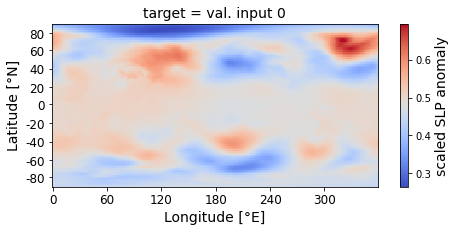

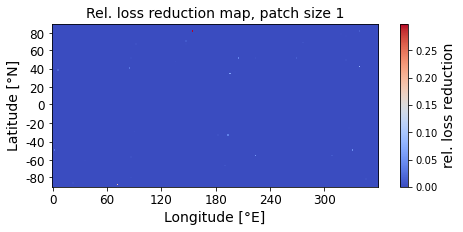

In [39]:
## Plot targets and corresponding rel. loss reduction maps:

# Specify number of samples to consider:
number_of_samples = n_samples

# Specify number of samples to plot:
plot_samples = 1

# Loop over samples:
for n in range(plot_samples):
    
    ## Plot target:
    fig, ax = plt.subplots(figsize=(8, 3))
    im = plt.imshow(val_input[n], cmap="coolwarm", interpolation='nearest')#, vmax=0.00022)
    cbar = plt.colorbar(im)
    cbar.set_label("scaled SLP anomaly", fontsize=14)
    plt.title('target = val. input '+str(n), fontsize=14)
    plt.xlabel('Longitude [°E]', fontsize=14)
    plt.ylabel('Latitude [°N]', fontsize=14)
    plt.xticks(np.arange(0, 192, step=32), [0, 60, 120, 180, 240, 300], fontsize=12)
    plt.yticks([5, 15, 26, 37, 47, 58, 69, 80, 90], [80, 60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)
    plt.show()


    # Plot rel. loss reduction map for current sample and patch sizes as heatmap:        
    fig, ax = plt.subplots(figsize=(8, 3))
    im = plt.imshow(rel_loss_reduction_maps[n,:,:], cmap="coolwarm", interpolation='nearest')#, vmax=0.00022)
    cbar = plt.colorbar(im)
    cbar.set_label('rel. loss reduction', fontsize=14)
    plt.title('Rel. loss reduction map, patch size '+str(patch_size), fontsize=14)
    plt.xlabel('Longitude [°E]', fontsize=14)
    plt.ylabel('Latitude [°N]', fontsize=14)
    plt.xticks(np.arange(0, 192, step=32), [0, 60, 120, 180, 240, 300], fontsize=12)
    plt.yticks([5, 15, 26, 37, 47, 58, 69, 80, 90], [80, 60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)
    plt.show()

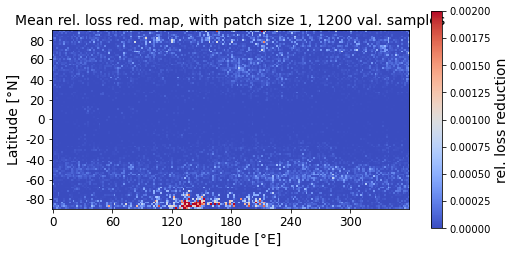

In [10]:
## relevance_1: TRAINING samples!
# Include first and last 600 samples, in total 1,200 samples, hence at the beginning of training data and at transition to val. data.
# patch_size = 1
# max_patch_num = 18
# max_acc_rel_loss_reduction = 1.0 

# Compute mean of rel. loss reduction maps, over desired number of considered validation samples:
mean_rel_loss_reduction_map = np.mean(rel_loss_reduction_maps[:number_of_samples],axis=0)

# Plot resulting mean rel. loss reduction map as heatmap:        
fig, ax = plt.subplots(figsize=(8, 4))
im = plt.imshow(mean_rel_loss_reduction_map, cmap="coolwarm", interpolation='nearest', vmax=0.002)
cbar = plt.colorbar(im)
cbar.set_label('rel. loss reduction', fontsize=14)
plt.title('Mean rel. loss red. map, with patch size '+str(patch_size)+', '+str(number_of_samples)+' val. samples', fontsize=14)
plt.xlabel('Longitude [°E]', fontsize=14)
plt.ylabel('Latitude [°N]', fontsize=14)
plt.xticks(np.arange(0, 192, step=32), [0, 60, 120, 180, 240, 300], fontsize=12)
plt.yticks([5, 15, 26, 37, 47, 58, 69, 80, 90], [80, 60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)
plt.show()

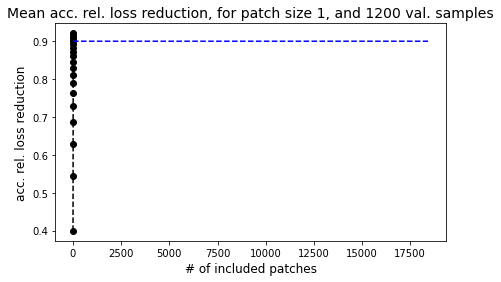

In [18]:
# Compute mean acc. rel. loss reduction, over desired number of considered validation samples:
mean_acc_rel_loss_reduction = np.mean(acc_rel_loss_reductions[:number_of_samples],axis=0)

# Plot mean acc. rel. loss reduction over desired number of patches to include:
fig, axes = plt.subplots(1,1,figsize=(7,4))

axes.plot(np.arange(0,n_patches,step=1)+1, mean_acc_rel_loss_reduction[:n_patches], color='black', marker='o', linestyle='--')
# Optionally add threshold:
axes.plot(np.arange(0,n_patches,step=1)+1, np.ones(n_patches)*0.9, color='blue', linestyle='--')
axes.set_title('Mean acc. rel. loss reduction, for patch size '+str(patch_size)+', and '+str(number_of_samples)+' val. samples', fontsize=14)
axes.set_xlabel('# of included patches', fontsize=12)
axes.set_ylabel('acc. rel. loss reduction', fontsize=12)
#axes.legend()
plt.show() 

In [20]:
# Check: How many patches do we need to exceed threshold in acc. rel. loss reduction?
print("For patch size", patch_size, "need to include", np.sum(np.isnan(patch_orders)==False,axis=1),
      "patches to surpass threshold of", max_acc_rel_loss_reduction, "acc. rel. loss reduction.")
print("On average over",n_samples,"samples, need",np.mean(np.sum(np.isnan(patch_orders)==False,axis=1)),"patches.")
print("That's",int(np.mean(np.sum(np.isnan(patch_orders)==False,axis=1))*patch_size**2),"grid points, or a rel. amount of missing values of",
     np.round(1-(np.mean(np.sum(np.isnan(patch_orders)==False,axis=1))*patch_size**2)/np.size(val_input[0]),4))

For patch size 1 need to include [18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18
 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18
 18 18] patches to surpass threshold of 1.0 acc. rel. loss reduction.
On average over 50 samples, need 18.0 patches.
That's 18 grid points, or a rel. amount of missing values of 0.999


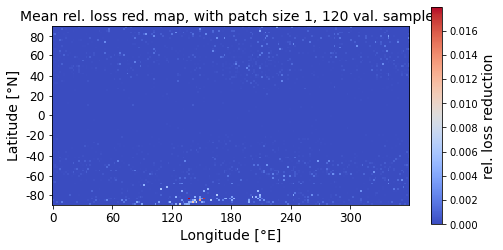

In [45]:
## relevance_2: TRAINING samples!
# Include first and last 60 samples, in total 120 samples, hence at the beginning of training data and at transition to val. data.
# patch_size = 1
# max_patch_num = 184
# max_acc_rel_loss_reduction = 1.0 

# Compute mean of rel. loss reduction maps, over desired number of considered validation samples:
mean_rel_loss_reduction_map = np.mean(rel_loss_reduction_maps[:number_of_samples],axis=0)

# Plot resulting mean rel. loss reduction map as heatmap:        
fig, ax = plt.subplots(figsize=(8, 4))
im = plt.imshow(mean_rel_loss_reduction_map, cmap="coolwarm", interpolation='nearest')#, vmax=0.002)
cbar = plt.colorbar(im)
cbar.set_label('rel. loss reduction', fontsize=14)
plt.title('Mean rel. loss red. map, with patch size '+str(patch_size)+', '+str(number_of_samples)+' val. samples', fontsize=14)
plt.xlabel('Longitude [°E]', fontsize=14)
plt.ylabel('Latitude [°N]', fontsize=14)
plt.xticks(np.arange(0, 192, step=32), [0, 60, 120, 180, 240, 300], fontsize=12)
plt.yticks([5, 15, 26, 37, 47, 58, 69, 80, 90], [80, 60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)
plt.show()

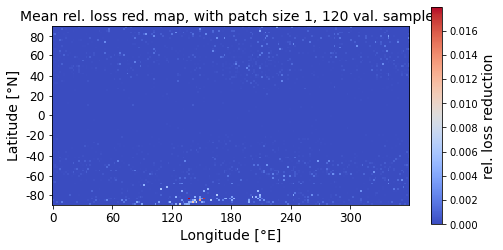

In [138]:
## relevance_3: TRAINING samples!
# Include first and last 60 samples, in total 120 samples, hence at the beginning of training data and at transition to val. data.
# patch_size = 1
# max_patch_num = 922
# max_acc_rel_loss_reduction = 1.0 

# Compute mean of rel. loss reduction maps, over desired number of considered validation samples:
mean_rel_loss_reduction_map = np.mean(rel_loss_reduction_maps[:number_of_samples],axis=0)

# Plot resulting mean rel. loss reduction map as heatmap:        
fig, ax = plt.subplots(figsize=(8, 4))
im = plt.imshow(mean_rel_loss_reduction_map, cmap="coolwarm", interpolation='nearest')#, vmax=0.002)
cbar = plt.colorbar(im)
cbar.set_label('rel. loss reduction', fontsize=14)
plt.title('Mean rel. loss red. map, with patch size '+str(patch_size)+', '+str(number_of_samples)+' val. samples', fontsize=14)
plt.xlabel('Longitude [°E]', fontsize=14)
plt.ylabel('Latitude [°N]', fontsize=14)
plt.xticks(np.arange(0, 192, step=32), [0, 60, 120, 180, 240, 300], fontsize=12)
plt.yticks([5, 15, 26, 37, 47, 58, 69, 80, 90], [80, 60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)
plt.show()

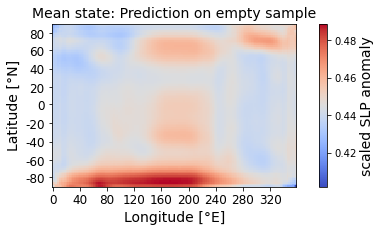

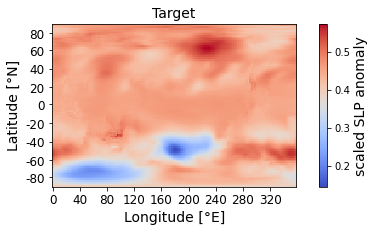

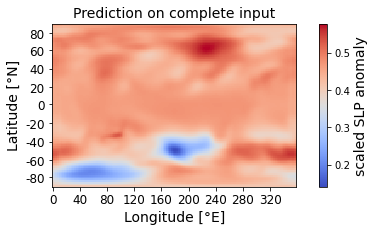

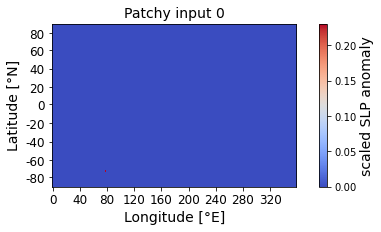

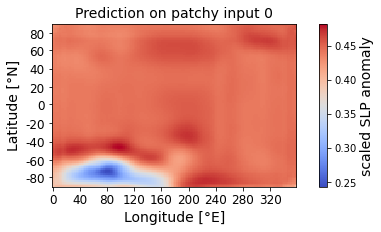

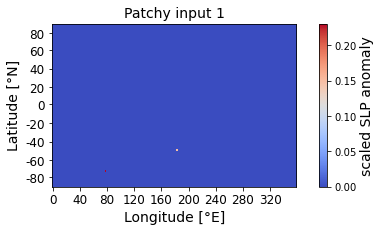

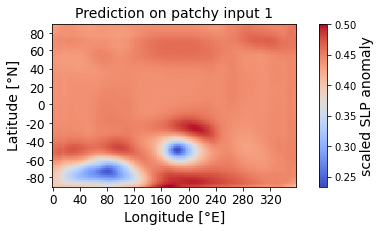

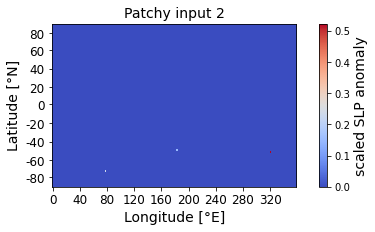

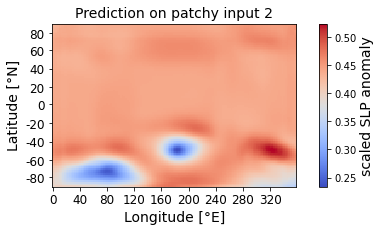

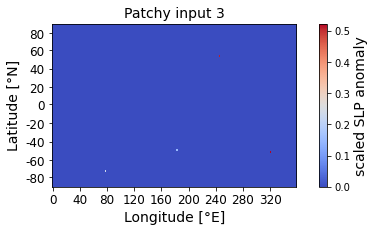

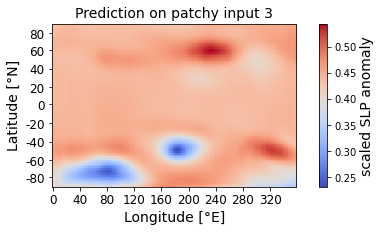

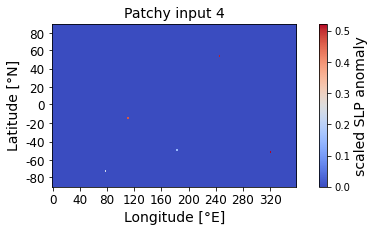

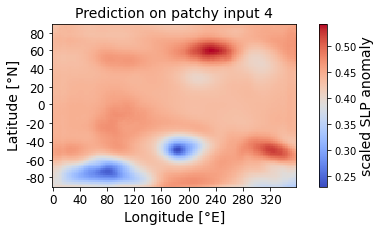

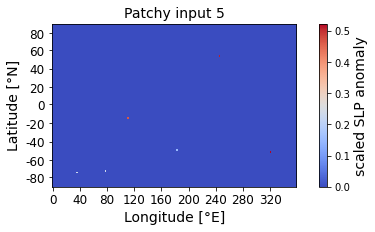

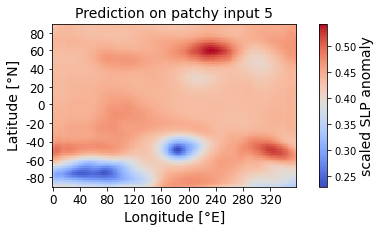

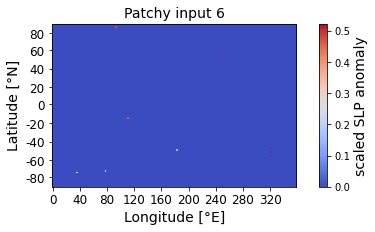

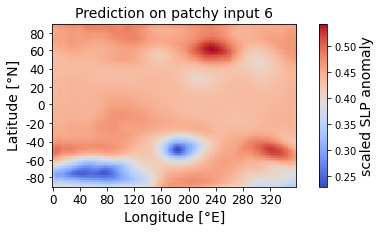

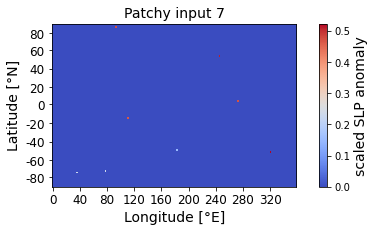

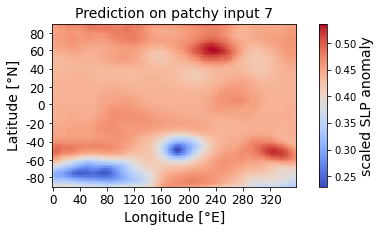

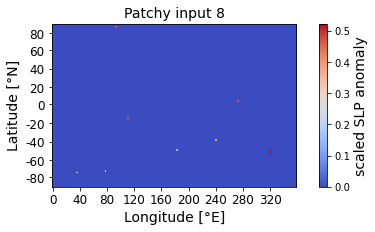

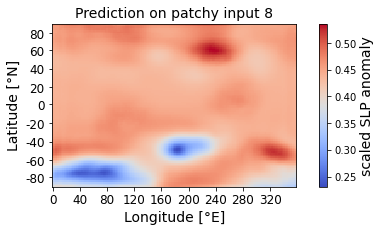

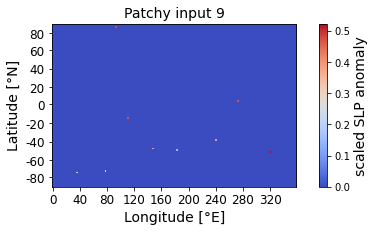

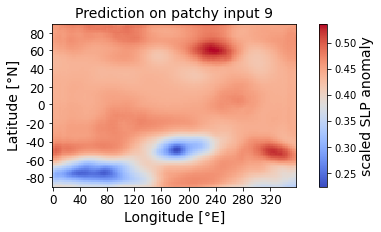

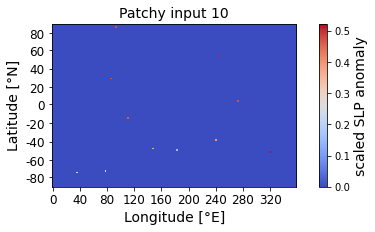

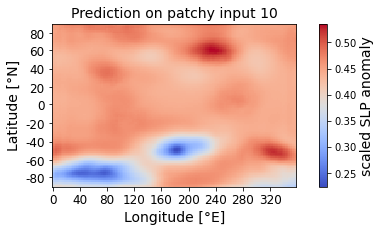

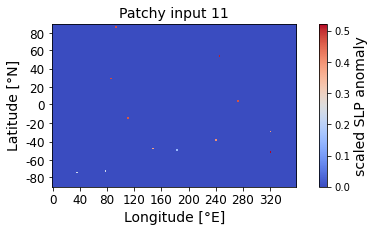

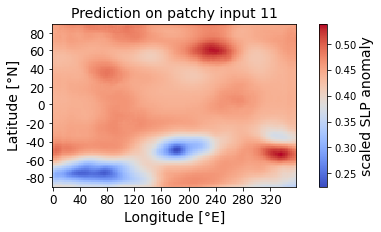

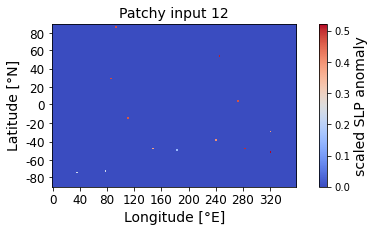

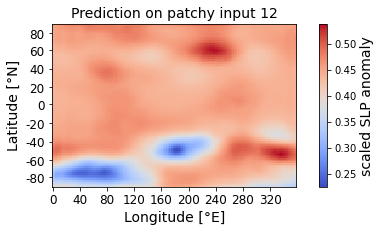

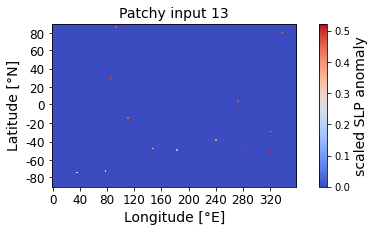

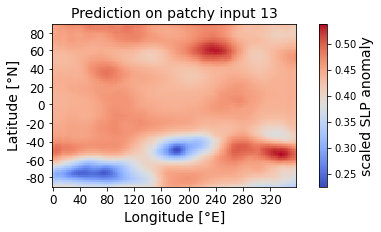

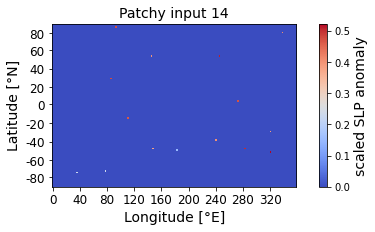

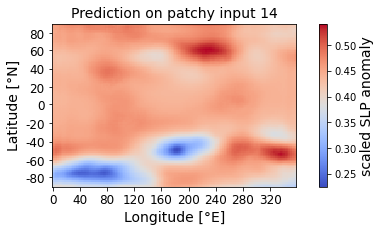

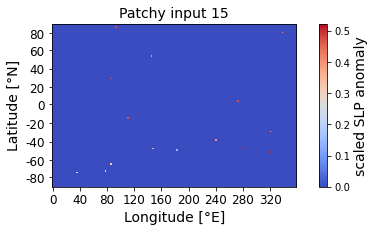

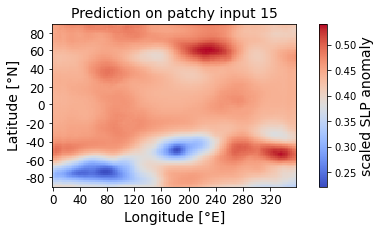

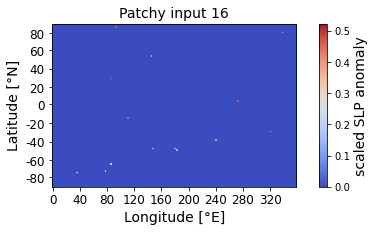

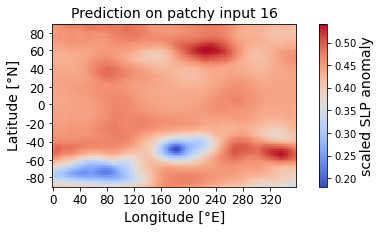

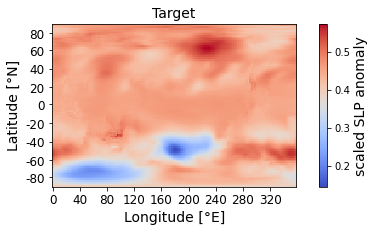

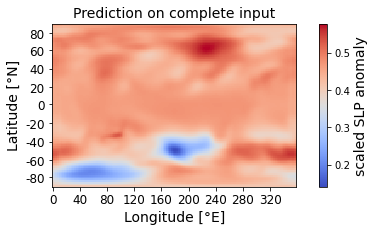

In [130]:
### Now look at single sample: How does reconstruction evolve, when successively adding patches, starting from empty sample:

# Pick sample
sample = 0

# Create empty sample of just ZEROs:
empty_sample = np.zeros((1, val_input[0:1].shape[1], val_input[0:1].shape[2]))

# Get mean state as prediciton on empty sample as input:
mean_state = model.predict(empty_sample)

# Get prediction on complete input sample:
complete_pred = model.predict(val_input[sample:sample+1])

# Plot prediction on empty sample:        
fig, ax = plt.subplots(figsize=(8, 3))
im = plt.imshow(mean_state[0,:,:,0], cmap="coolwarm", interpolation='nearest')#, vmax=0.00022)
cbar = plt.colorbar(im)
cbar.set_label('scaled SLP anomaly', fontsize=14)
plt.title('Mean state: Prediction on empty sample', fontsize=14)
plt.xlabel('Longitude [°E]', fontsize=14)
plt.ylabel('Latitude [°N]', fontsize=14)
plt.xticks(np.arange(0, 144, step=16), [0, 40, 80, 120, 160, 200, 240, 280, 320], fontsize=12)
plt.yticks([5, 15, 26, 37, 47, 58, 69, 80, 90], [80, 60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)
plt.show()

# Plot target:        
fig, ax = plt.subplots(figsize=(8, 3))
im = plt.imshow(val_input[sample], cmap="coolwarm", interpolation='nearest')#, vmax=0.00022)
cbar = plt.colorbar(im)
cbar.set_label('scaled SLP anomaly', fontsize=14)
plt.title('Target', fontsize=14)
plt.xlabel('Longitude [°E]', fontsize=14)
plt.ylabel('Latitude [°N]', fontsize=14)
plt.xticks(np.arange(0, 144, step=16), [0, 40, 80, 120, 160, 200, 240, 280, 320], fontsize=12)
plt.yticks([5, 15, 26, 37, 47, 58, 69, 80, 90], [80, 60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)
plt.show()

# Plot prediction on complete input:        
fig, ax = plt.subplots(figsize=(8, 3))
im = plt.imshow(complete_pred[0,:,:,0], cmap="coolwarm", interpolation='nearest')#, vmax=0.00022)
cbar = plt.colorbar(im)
cbar.set_label('scaled SLP anomaly', fontsize=14)
plt.title('Prediction on complete input', fontsize=14)
plt.xlabel('Longitude [°E]', fontsize=14)
plt.ylabel('Latitude [°N]', fontsize=14)
plt.xticks(np.arange(0, 144, step=16), [0, 40, 80, 120, 160, 200, 240, 280, 320], fontsize=12)
plt.yticks([5, 15, 26, 37, 47, 58, 69, 80, 90], [80, 60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)
plt.show()

## Create patches according to patch_order:

# Get number of included patches:
num_patches = np.sum(np.isnan(patch_orders)==False,axis=1)[sample]

# Initialize storage for patches. Dimension (# of patches, latitude, longitude)
patches = np.zeros((num_patches, val_input[0:1].shape[1], val_input[0:1].shape[2]))

# Run over patch order:
for n in range(num_patches):

    # Get current patch index:
    patch_index = patch_orders[sample,n]

    # Get x and y coordinate from current patch index:
    y = patch_index // n_lon
    x = patch_index % n_lon    
   
    # Store mask for current patch:
    patches[n,int(y*patch_size):int((y+1)*patch_size),int(x*patch_size):int((x+1)*patch_size)] = 1 
    
    # Copy current patch as basis for next patch:
    if n < num_patches-1:
        patches[n+1] = patches[n]

# Expand dimensions of patches: Have last dimension for channel (=1), to match requirements for CNN inputs.
patches_extended = np.expand_dims(patches, axis=-1)

# Create input samples from first validation sample:
patchy_input = patches_extended * val_input[sample:sample+1]

# Get model predictions on patchy inputs:
patchy_pred = model.predict(patchy_input)

## Plot patchy inputs and corresponding predictions:

# Run over number of patches to include:
for n in range(num_patches):
    
    fig, ax = plt.subplots(figsize=(8, 3))
    im = plt.imshow(patchy_input[n], cmap="coolwarm", interpolation='nearest')#, vmax=0.00022)
    cbar = plt.colorbar(im)
    cbar.set_label('scaled SLP anomaly', fontsize=14)
    plt.title('Patchy input '+str(n), fontsize=14)
    plt.xlabel('Longitude [°E]', fontsize=14)
    plt.ylabel('Latitude [°N]', fontsize=14)
    plt.xticks(np.arange(0, 144, step=16), [0, 40, 80, 120, 160, 200, 240, 280, 320], fontsize=12)
    plt.yticks([5, 15, 26, 37, 47, 58, 69, 80, 90], [80, 60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)
    plt.show()
    
    fig, ax = plt.subplots(figsize=(8, 3))
    im = plt.imshow(patchy_pred[n], cmap="coolwarm", interpolation='nearest')#, vmax=0.00022)
    cbar = plt.colorbar(im)
    cbar.set_label('scaled SLP anomaly', fontsize=14)
    plt.title('Prediction on patchy input '+str(n), fontsize=14)
    plt.xlabel('Longitude [°E]', fontsize=14)
    plt.ylabel('Latitude [°N]', fontsize=14)
    plt.xticks(np.arange(0, 144, step=16), [0, 40, 80, 120, 160, 200, 240, 280, 320], fontsize=12)
    plt.yticks([5, 15, 26, 37, 47, 58, 69, 80, 90], [80, 60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)
    plt.show()
    
# Again: Plot target:        
fig, ax = plt.subplots(figsize=(8, 3))
im = plt.imshow(val_input[sample], cmap="coolwarm", interpolation='nearest')#, vmax=0.00022)
cbar = plt.colorbar(im)
cbar.set_label('scaled SLP anomaly', fontsize=14)
plt.title('Target', fontsize=14)
plt.xlabel('Longitude [°E]', fontsize=14)
plt.ylabel('Latitude [°N]', fontsize=14)
plt.xticks(np.arange(0, 144, step=16), [0, 40, 80, 120, 160, 200, 240, 280, 320], fontsize=12)
plt.yticks([5, 15, 26, 37, 47, 58, 69, 80, 90], [80, 60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)
plt.show()

# Again: Plot prediction on complete input:        
fig, ax = plt.subplots(figsize=(8, 3))
im = plt.imshow(complete_pred[0,:,:,0], cmap="coolwarm", interpolation='nearest')#, vmax=0.00022)
cbar = plt.colorbar(im)
cbar.set_label('scaled SLP anomaly', fontsize=14)
plt.title('Prediction on complete input', fontsize=14)
plt.xlabel('Longitude [°E]', fontsize=14)
plt.ylabel('Latitude [°N]', fontsize=14)
plt.xticks(np.arange(0, 144, step=16), [0, 40, 80, 120, 160, 200, 240, 280, 320], fontsize=12)
plt.yticks([5, 15, 26, 37, 47, 58, 69, 80, 90], [80, 60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)
plt.show()

### Extend Kmeans clustering to 3D: Take actual rel. loss reduction into account, not only x-y-position of grid points

In [11]:
### Now have a mean acc. rel. loss map for patch size 1, hence on grip point scale.
### With a total number of (n_lat x n_lon) 96 x 144 = 13,824 grid points, we define fixed masks from the most relevant XX grid points.

# 14 grid points --> 99.9% missing values
n_gridpoints_999 = int(np.round(0.001*n_lat*n_lon,0))
# 138 grid points --> 99% missing values
n_gridpoints_99 = int(np.round(0.01*n_lat*n_lon,0))
# 691 grid points --> 95% missing values
n_gridpoints_95 = int(np.round(0.05*n_lat*n_lon,0))

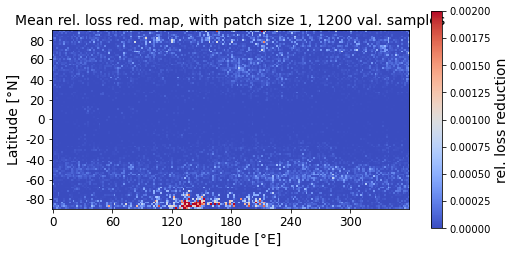

In [12]:
## relevance_1: TRAINING samples!
# Include first and last 600 samples, in total 1,200 samples, hence at the beginning of training data and at transition to val. data.
# patch_size = 1
# max_patch_num = 18
# max_acc_rel_loss_reduction = 1.0 

# Compute mean of rel. loss reduction maps, over desired number of considered validation samples:
mean_rel_loss_reduction_map = np.mean(rel_loss_reduction_maps[:number_of_samples],axis=0)

# Plot resulting mean rel. loss reduction map as heatmap:        
fig, ax = plt.subplots(figsize=(8, 4))
im = plt.imshow(mean_rel_loss_reduction_map, cmap="coolwarm", interpolation='nearest', vmax=0.002)
cbar = plt.colorbar(im)
cbar.set_label('rel. loss reduction', fontsize=14)
plt.title('Mean rel. loss red. map, with patch size '+str(patch_size)+', '+str(number_of_samples)+' val. samples', fontsize=14)
plt.xlabel('Longitude [°E]', fontsize=14)
plt.ylabel('Latitude [°N]', fontsize=14)
plt.xticks(np.arange(0, 192, step=32), [0, 60, 120, 180, 240, 300], fontsize=12)
plt.yticks([5, 15, 26, 37, 47, 58, 69, 80, 90], [80, 60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)
plt.show()

In [13]:
# Look for number of grid points in mean rel. loss reduction map with non-zero entry:
print("non-zero entries in mean rel. loss reduction map: ", np.sum(mean_rel_loss_reduction_map!=0))

non-zero entries in mean rel. loss reduction map:  10290


In [14]:
## Start with 3D clustering of x/y positions and its rel. loss reduction (z) for non-zero entries:

# Compute max. rel. loss reduction, for scaling of z-component:
max_rel_loss_red = np.max(mean_rel_loss_reduction_map)

# Create tuples of x/y/z positions:
xyz = []

# Loop over longitude:
for x in range(n_lon):
    
    # Loop over latitude:
    for y in range(n_lat):
        
        # Check for non-zero entry in mean rel. loss reduction map:
        if mean_rel_loss_reduction_map[y,x] > 0.0:
            
#         # Alternatively check for grid points, that exceed threshold in patch_counts:
#         if patch_counts_2D[y,x] > 5:
            
            # Store xyz-tuple, scaled to [0,1] in either dimension:
            xyz.append([x/(n_lon-1), y/(n_lat-1), mean_rel_loss_reduction_map[y,x]/max_rel_loss_red])

# Convert list of xyz-tuples to np.array:
xyz = np.array(xyz)

# Output number of obtained tuples:
print("number of xyz-tuples representing non-zero entries in mean rel. loss reduction map: ", len(xyz))

number of xyz-tuples representing non-zero entries in mean rel. loss reduction map:  10290


In [15]:
# Get clusters from Kmeans algorithms with pre-specified number of clusters = 14 (=0.1%):
kmeans_999_3D = KMeans(n_clusters=18, init='k-means++', max_iter=300, n_init=10, random_state=0)
clusters = kmeans_999_3D.fit_predict(xyz)

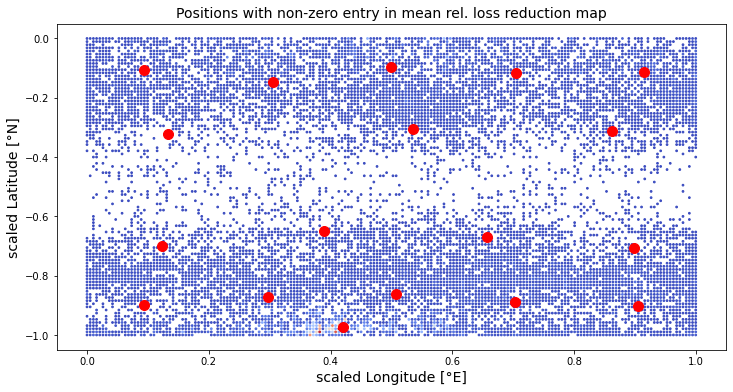

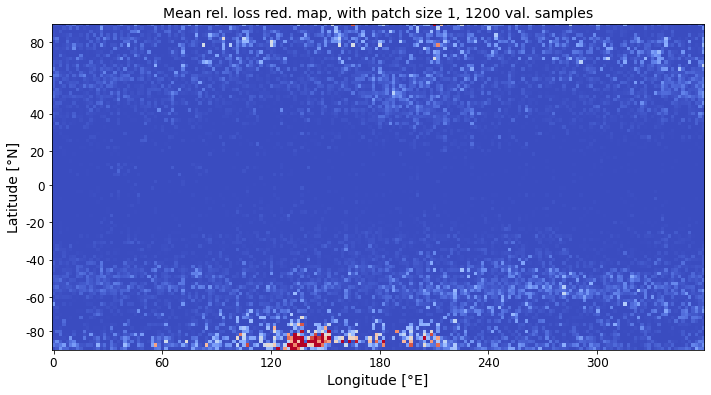

In [16]:
# Show obtained positions as scatter plot:
fig, ax = plt.subplots(figsize=(12,6))
plt.scatter(xyz[:,0], -xyz[:,1], s=3, c=xyz[:,2], cmap='coolwarm', vmin=0.0)#, vmax=0.002)
plt.scatter(kmeans_999_3D.cluster_centers_[:, 0], -kmeans_999_3D.cluster_centers_[:, 1], s=100, c='red')
plt.title('Positions with non-zero entry in mean rel. loss reduction map', fontsize=14)
plt.xlabel('scaled Longitude [°E]', fontsize=14)
plt.ylabel('scaled Latitude [°N]', fontsize=14)
# plt.xticks(np.arange(0, 144, step=16), [0, 40, 80, 120, 160, 200, 240, 280, 320], fontsize=12)
# plt.yticks([5, 15, 26, 37, 47, 58, 69, 80, 90], [80, 60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)
plt.show()

# Plot resulting mean rel. loss reduction map as heatmap:        
fig, ax = plt.subplots(figsize=(12, 6))
im = plt.imshow(mean_rel_loss_reduction_map, cmap="coolwarm", interpolation='nearest', vmax=0.002)
#cbar = plt.colorbar(im)
cbar.set_label('rel. loss reduction', fontsize=14)
plt.title('Mean rel. loss red. map, with patch size '+str(patch_size)+', '+str(number_of_samples)+' val. samples', fontsize=14)
plt.xlabel('Longitude [°E]', fontsize=14)
plt.ylabel('Latitude [°N]', fontsize=14)
plt.xticks(np.arange(0, 192, step=32), [0, 60, 120, 180, 240, 300], fontsize=12)
plt.yticks([5, 15, 26, 37, 47, 58, 69, 80, 90], [80, 60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)
plt.show()

In [17]:
## Convert obtained cluster centers to former lat/lon scales:

# Initialize storage:
cluster_centers_999_3D = np.zeros(kmeans_999_3D.cluster_centers_.shape).astype(int)

# Unscale latitude and longitude dimensions.
# Note: For FOCI need to flip latitude.
cluster_centers_999_3D[:,0] = np.round(kmeans_999_3D.cluster_centers_[:,0]*(n_lon-1),0).astype(int)
cluster_centers_999_3D[:,1] = np.round(-kmeans_999_3D.cluster_centers_[:,1]*(n_lat-1)+(n_lat-1),0).astype(int)

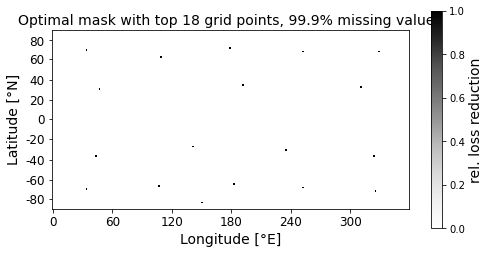

In [18]:
## Create optimal mask from cluster centers:

# Initialize two-dimensional boolean mask of FALSE, dimension (n_lat, n_lon):
mask_999_kmeans_3D = (np.zeros((n_lat,n_lon))!=0)

# Loop over cluster centers:
for xyz in cluster_centers_999_3D:
    
    # Set grid points to True:
    mask_999_kmeans_3D[xyz[1],xyz[0]]=True
    
# Plot optimal mask:
fig, ax = plt.subplots(figsize=(8, 4))
im = plt.imshow(np.flip(mask_999_kmeans_3D,axis=0), cmap="Greys", interpolation='nearest')#, vmax=0.00022)
cbar = plt.colorbar(im)
cbar.set_label('rel. loss reduction', fontsize=14)
plt.title('Optimal mask with top ' + str(n_gridpoints_999) + ' grid points, 99.9% missing values', fontsize=14)
plt.xlabel('Longitude [°E]', fontsize=14)
plt.ylabel('Latitude [°N]', fontsize=14)
plt.xticks(np.arange(0, 192, step=32), [0, 60, 120, 180, 240, 300], fontsize=12)
plt.yticks([5, 15, 26, 37, 47, 58, 69, 80, 90], [80, 60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)
plt.show()

In [19]:
# Set path to store optimal missing masks:
path_to_store_masks = Path('GitGeomar/marco-landt-hayen/reconstruct_missing_data_results/'+model_config+'_'+feature_short+'_'+source+'_'
                      +mask_type+'_'+missing_type+'_factor_'+str(augmentation_factor)+run+exp_name)

print(path_to_store_masks)

GitGeomar/marco-landt-hayen/reconstruct_missing_data_results/unet_4conv_slp_FOCI_variable_range_50_999_factor_3_final/relevance_1


In [20]:
## Store masks, to re-use in batch:
# np.save(path_to_store_masks / "optimal_sampling_mask_999_flipped.npy", mask_999_kmeans_3D)

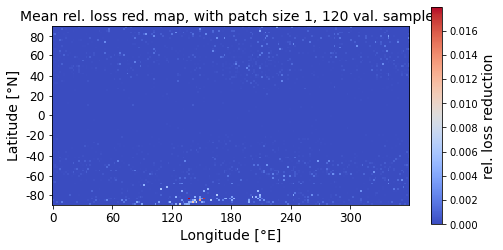

In [26]:
## relevance_2: TRAINING samples!
# Include first and last 60 samples, in total 120 samples, hence at the beginning of training data and at transition to val. data.
# patch_size = 1
# max_patch_num = 184
# max_acc_rel_loss_reduction = 1.0 

# Compute mean of rel. loss reduction maps, over desired number of considered validation samples:
mean_rel_loss_reduction_map = np.mean(rel_loss_reduction_maps[:number_of_samples],axis=0)

# Plot resulting mean rel. loss reduction map as heatmap:        
fig, ax = plt.subplots(figsize=(8, 4))
im = plt.imshow(mean_rel_loss_reduction_map, cmap="coolwarm", interpolation='nearest')#, vmax=0.002)
cbar = plt.colorbar(im)
cbar.set_label('rel. loss reduction', fontsize=14)
plt.title('Mean rel. loss red. map, with patch size '+str(patch_size)+', '+str(number_of_samples)+' val. samples', fontsize=14)
plt.xlabel('Longitude [°E]', fontsize=14)
plt.ylabel('Latitude [°N]', fontsize=14)
plt.xticks(np.arange(0, 192, step=32), [0, 60, 120, 180, 240, 300], fontsize=12)
plt.yticks([5, 15, 26, 37, 47, 58, 69, 80, 90], [80, 60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)
plt.show()

In [27]:
# Look for number of grid points in mean rel. loss reduction map with non-zero entry:
print("non-zero entries in mean rel. loss reduction map: ", np.sum(mean_rel_loss_reduction_map!=0))

non-zero entries in mean rel. loss reduction map:  5232


In [28]:
## Start with 3D clustering of x/y positions and its rel. loss reduction (z) for non-zero entries:

# Compute max. rel. loss reduction, for scaling of z-component:
max_rel_loss_red = np.max(mean_rel_loss_reduction_map)

# Create tuples of x/y/z positions:
xyz = []

# Loop over longitude:
for x in range(n_lon):
    
    # Loop over latitude:
    for y in range(n_lat):
        
        # Check for non-zero entry in mean rel. loss reduction map:
        if mean_rel_loss_reduction_map[y,x] > 0.0:
            
#         # Alternatively check for grid points, that exceed threshold in patch_counts:
#         if patch_counts_2D[y,x] > 5:
            
            # Store xyz-tuple, scaled to [0,1] in either dimension:
            xyz.append([x/(n_lon-1), y/(n_lat-1), mean_rel_loss_reduction_map[y,x]/max_rel_loss_red])

# Convert list of xyz-tuples to np.array:
xyz = np.array(xyz)

# Output number of obtained tuples:
print("number of xyz-tuples representing non-zero entries in mean rel. loss reduction map: ", len(xyz))

number of xyz-tuples representing non-zero entries in mean rel. loss reduction map:  5232


In [29]:
# Get clusters from Kmeans algorithms with pre-specified number of clusters = 138 (=1%):
kmeans_99_3D = KMeans(n_clusters=184, init='k-means++', max_iter=300, n_init=10, random_state=0)
clusters = kmeans_99_3D.fit_predict(xyz)

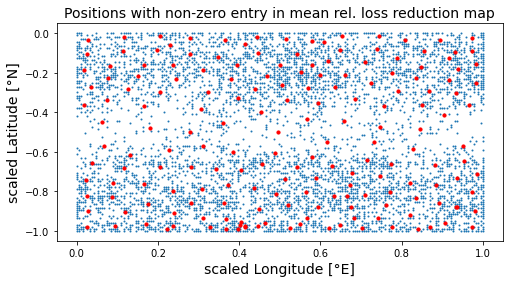

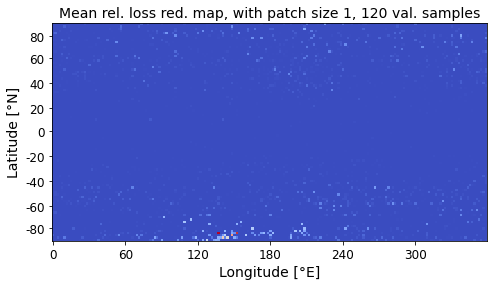

In [30]:
# Show obtained positions as scatter plot:
fig, ax = plt.subplots(figsize=(8,4))
plt.scatter(xyz[:,0], -xyz[:,1], s=1)
plt.scatter(kmeans_99_3D.cluster_centers_[:, 0], -kmeans_99_3D.cluster_centers_[:, 1], s=10, c='red')
plt.title('Positions with non-zero entry in mean rel. loss reduction map', fontsize=14)
plt.xlabel('scaled Longitude [°E]', fontsize=14)
plt.ylabel('scaled Latitude [°N]', fontsize=14)
# plt.xticks(np.arange(0, 144, step=16), [0, 40, 80, 120, 160, 200, 240, 280, 320], fontsize=12)
# plt.yticks([5, 15, 26, 37, 47, 58, 69, 80, 90], [80, 60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)
plt.show()

# Plot resulting mean rel. loss reduction map as heatmap:        
fig, ax = plt.subplots(figsize=(8, 4))
im = plt.imshow(mean_rel_loss_reduction_map, cmap="coolwarm", interpolation='nearest')#, vmax=0.002)
#cbar = plt.colorbar(im)
cbar.set_label('rel. loss reduction', fontsize=14)
plt.title('Mean rel. loss red. map, with patch size '+str(patch_size)+', '+str(number_of_samples)+' val. samples', fontsize=14)
plt.xlabel('Longitude [°E]', fontsize=14)
plt.ylabel('Latitude [°N]', fontsize=14)
plt.xticks(np.arange(0, 192, step=32), [0, 60, 120, 180, 240, 300], fontsize=12)
plt.yticks([5, 15, 26, 37, 47, 58, 69, 80, 90], [80, 60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)
plt.show()

In [31]:
## Convert obtained cluster centers to former lat/lon scales:

# Initialize storage:
cluster_centers_99_3D = np.zeros(kmeans_99_3D.cluster_centers_.shape).astype(int)

# Unscale latitude and longitude dimensions.
# Note: For FOCI need to flip latitude.
cluster_centers_99_3D[:,0] = np.round(kmeans_99_3D.cluster_centers_[:,0]*(n_lon-1),0).astype(int)
cluster_centers_99_3D[:,1] = np.round(-kmeans_99_3D.cluster_centers_[:,1]*(n_lat-1)+(n_lat-1),0).astype(int)

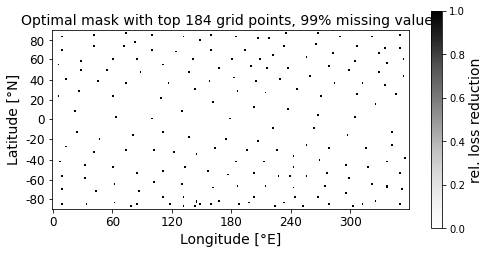

In [32]:
## Create optimal mask from cluster centers:

# Initialize two-dimensional boolean mask of FALSE, dimension (n_lat, n_lon):
mask_99_kmeans_3D = (np.zeros((n_lat,n_lon))!=0)

# Loop over cluster centers:
for xyz in cluster_centers_99_3D:
    
    # Set grid points to True:
    mask_99_kmeans_3D[xyz[1],xyz[0]]=True
    
# Plot optimal mask:
fig, ax = plt.subplots(figsize=(8, 4))
im = plt.imshow(np.flip(mask_99_kmeans_3D,axis=0), cmap="Greys", interpolation='nearest')#, vmax=0.00022)
cbar = plt.colorbar(im)
cbar.set_label('rel. loss reduction', fontsize=14)
plt.title('Optimal mask with top ' + str(n_gridpoints_99) + ' grid points, 99% missing values', fontsize=14)
plt.xlabel('Longitude [°E]', fontsize=14)
plt.ylabel('Latitude [°N]', fontsize=14)
plt.xticks(np.arange(0, 192, step=32), [0, 60, 120, 180, 240, 300], fontsize=12)
plt.yticks([5, 15, 26, 37, 47, 58, 69, 80, 90], [80, 60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)
plt.show()

In [33]:
# Set path to store optimal missing masks:
path_to_store_masks = Path('GitGeomar/marco-landt-hayen/reconstruct_missing_data_results/'+model_config+'_'+feature_short+'_'+source+'_'
                      +mask_type+'_'+missing_type+'_factor_'+str(augmentation_factor)+run+exp_name)

print(path_to_store_masks)

GitGeomar/marco-landt-hayen/reconstruct_missing_data_results/unet_4conv_slp_FOCI_variable_range_50_999_factor_3_final/relevance_2


In [34]:
## Store masks, to re-use in batch:
# np.save(path_to_store_masks / "optimal_sampling_mask_99_flipped.npy", mask_99_kmeans_3D)

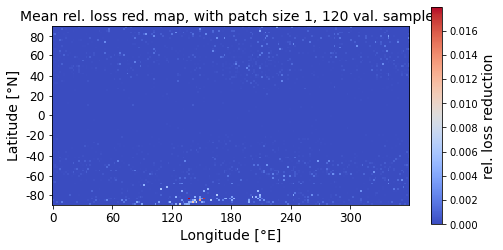

In [40]:
## relevance_3: TRAINING samples!
# Include first and last 60 samples, in total 120 samples, hence at the beginning of training data and at transition to val. data.
# patch_size = 1
# max_patch_num = 922
# max_acc_rel_loss_reduction = 1.0 

# Compute mean of rel. loss reduction maps, over desired number of considered validation samples:
mean_rel_loss_reduction_map = np.mean(rel_loss_reduction_maps[:number_of_samples],axis=0)

# Plot resulting mean rel. loss reduction map as heatmap:        
fig, ax = plt.subplots(figsize=(8, 4))
im = plt.imshow(mean_rel_loss_reduction_map, cmap="coolwarm", interpolation='nearest')#, vmax=0.002)
cbar = plt.colorbar(im)
cbar.set_label('rel. loss reduction', fontsize=14)
plt.title('Mean rel. loss red. map, with patch size '+str(patch_size)+', '+str(number_of_samples)+' val. samples', fontsize=14)
plt.xlabel('Longitude [°E]', fontsize=14)
plt.ylabel('Latitude [°N]', fontsize=14)
plt.xticks(np.arange(0, 192, step=32), [0, 60, 120, 180, 240, 300], fontsize=12)
plt.yticks([5, 15, 26, 37, 47, 58, 69, 80, 90], [80, 60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)
plt.show()

In [41]:
# Look for number of grid points in mean rel. loss reduction map with non-zero entry:
print("non-zero entries in mean rel. loss reduction map: ", np.sum(mean_rel_loss_reduction_map!=0))

non-zero entries in mean rel. loss reduction map:  5232


In [42]:
## Start with 3D clustering of x/y positions and its rel. loss reduction (z) for non-zero entries:

# Compute max. rel. loss reduction, for scaling of z-component:
max_rel_loss_red = np.max(mean_rel_loss_reduction_map)

# Create tuples of x/y/z positions:
xyz = []

# Loop over longitude:
for x in range(n_lon):
    
    # Loop over latitude:
    for y in range(n_lat):
        
        # Check for non-zero entry in mean rel. loss reduction map:
        if mean_rel_loss_reduction_map[y,x] > 0.0:
            
#         # Alternatively check for grid points, that exceed threshold in patch_counts:
#         if patch_counts_2D[y,x] > 5:
            
            # Store xyz-tuple, scaled to [0,1] in either dimension:
            xyz.append([x/(n_lon-1), y/(n_lat-1), mean_rel_loss_reduction_map[y,x]/max_rel_loss_red])

# Convert list of xyz-tuples to np.array:
xyz = np.array(xyz)

# Output number of obtained tuples:
print("number of xyz-tuples representing non-zero entries in mean rel. loss reduction map: ", len(xyz))

number of xyz-tuples representing non-zero entries in mean rel. loss reduction map:  5232


In [43]:
# Get clusters from Kmeans algorithms with pre-specified number of clusters = 138 (=1%):
kmeans_95_3D = KMeans(n_clusters=922, init='k-means++', max_iter=300, n_init=10, random_state=0)
clusters = kmeans_95_3D.fit_predict(xyz)

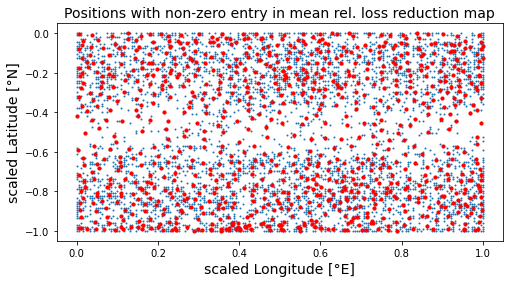

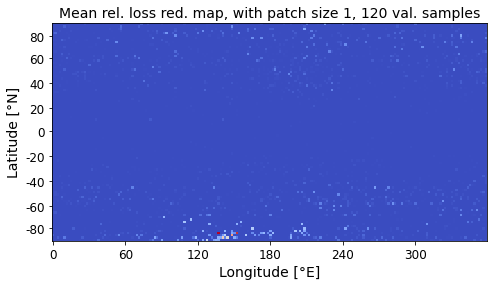

In [44]:
# Show obtained positions as scatter plot:
fig, ax = plt.subplots(figsize=(8,4))
plt.scatter(xyz[:,0], -xyz[:,1], s=1)
plt.scatter(kmeans_95_3D.cluster_centers_[:, 0], -kmeans_95_3D.cluster_centers_[:, 1], s=10, c='red')
plt.title('Positions with non-zero entry in mean rel. loss reduction map', fontsize=14)
plt.xlabel('scaled Longitude [°E]', fontsize=14)
plt.ylabel('scaled Latitude [°N]', fontsize=14)
# plt.xticks(np.arange(0, 144, step=16), [0, 40, 80, 120, 160, 200, 240, 280, 320], fontsize=12)
# plt.yticks([5, 15, 26, 37, 47, 58, 69, 80, 90], [80, 60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)
plt.show()

# Plot resulting mean rel. loss reduction map as heatmap:        
fig, ax = plt.subplots(figsize=(8, 4))
im = plt.imshow(mean_rel_loss_reduction_map, cmap="coolwarm", interpolation='nearest')#, vmax=0.002)
#cbar = plt.colorbar(im)
cbar.set_label('rel. loss reduction', fontsize=14)
plt.title('Mean rel. loss red. map, with patch size '+str(patch_size)+', '+str(number_of_samples)+' val. samples', fontsize=14)
plt.xlabel('Longitude [°E]', fontsize=14)
plt.ylabel('Latitude [°N]', fontsize=14)
plt.xticks(np.arange(0, 192, step=32), [0, 60, 120, 180, 240, 300], fontsize=12)
plt.yticks([5, 15, 26, 37, 47, 58, 69, 80, 90], [80, 60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)
plt.show()

In [45]:
## Convert obtained cluster centers to former lat/lon scales:

# Initialize storage:
cluster_centers_95_3D = np.zeros(kmeans_95_3D.cluster_centers_.shape).astype(int)

# Unscale latitude and longitude dimensions.
# Note: For FOCI need to flip latitude.
cluster_centers_95_3D[:,0] = np.round(kmeans_95_3D.cluster_centers_[:,0]*(n_lon-1),0).astype(int)
cluster_centers_95_3D[:,1] = np.round(-kmeans_95_3D.cluster_centers_[:,1]*(n_lat-1)+(n_lat-1),0).astype(int)

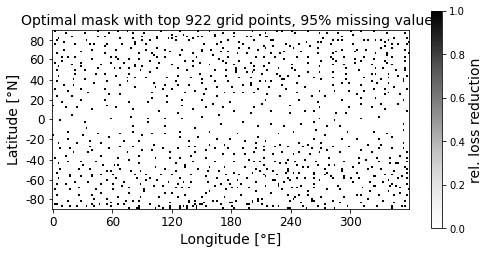

In [46]:
## Create optimal mask from cluster centers:

# Initialize two-dimensional boolean mask of FALSE, dimension (n_lat, n_lon):
mask_95_kmeans_3D = (np.zeros((n_lat,n_lon))!=0)

# Loop over cluster centers:
for xyz in cluster_centers_95_3D:
    
    # Set grid points to True:
    mask_95_kmeans_3D[xyz[1],xyz[0]]=True
    
# Plot optimal mask:
fig, ax = plt.subplots(figsize=(8, 4))
im = plt.imshow(np.flip(mask_95_kmeans_3D,axis=0), cmap="Greys", interpolation='nearest')#, vmax=0.00022)
cbar = plt.colorbar(im)
cbar.set_label('rel. loss reduction', fontsize=14)
plt.title('Optimal mask with top ' + str(n_gridpoints_95) + ' grid points, 95% missing values', fontsize=14)
plt.xlabel('Longitude [°E]', fontsize=14)
plt.ylabel('Latitude [°N]', fontsize=14)
plt.xticks(np.arange(0, 192, step=32), [0, 60, 120, 180, 240, 300], fontsize=12)
plt.yticks([5, 15, 26, 37, 47, 58, 69, 80, 90], [80, 60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)
plt.show()

In [47]:
# Set path to store optimal missing masks:
path_to_store_masks = Path('GitGeomar/marco-landt-hayen/reconstruct_missing_data_results/'+model_config+'_'+feature_short+'_'+source+'_'
                      +mask_type+'_'+missing_type+'_factor_'+str(augmentation_factor)+run+exp_name)

print(path_to_store_masks)

GitGeomar/marco-landt-hayen/reconstruct_missing_data_results/unet_4conv_slp_FOCI_variable_range_50_999_factor_3_final/relevance_3


In [48]:
## Store masks, to re-use in batch:
#np.save(path_to_store_masks / "optimal_sampling_mask_95_flipped.npy", mask_95_kmeans_3D)